# Schrodinger's Equation

Welcome to *Schrodinger's Equation*, the bonus notebook for Module 4 of ["Practical Numerical Methods with Python"](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about)!

In this lesson we will utilize the  method we learned in the fifth notebook of module 4: The ["Crank-Nicolson"](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_05_Crank-Nicolson.ipynb) method. We previously used this method to numerically solve the diffusion equation. In this notebook we will evalute the numerical solution applied to the Schrodinger equation:

\begin{equation}
i\hbar\frac{\partial}{\partial t}\psi(x, t) = -\frac{\hbar^2}{2m} \nabla^2\psi(x, t) + V(x)\psi(x,t) = \hat H\psi(x,t)
\end{equation}

Where $\psi(x,t)$ is the wave function, $V(x)$ is the potential energy, $\hbar$ is Planck's constant ($h$) divided by $2\pi$,  $i$ is an imaginary term, and $\hat H$ is the Hamiltonian operator. 

The Schrodinger equation is a parabolic partial differential equation which is the basis for solving problems related to quantum mechanics. This equation is first order in time and second order in space. 

In quantum mechanics, the Schrodinger equation is specifically used to find the wave function which characterizes a particle over a period of time. These particles can include molecules, atoms, and electrons. The Hamiltonian operator represents the total the energy of the system, being the summation of the kinetic and potential energies of the system. Check out this ["Wikipedia article"](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation#Historical_background_and_development) to learn more about the background of the Schrodinger equation!

You should notice the complex term in the equation, this is something we have never dealt with before. Don't worry, Python is equipped to handle operators like this and we will dicuss this later in the lesson!

For this lesson, we will solve a simple problem using the Crank-Nicolson method to find the solution of the Schrodinger equation: The Particle in a Box.

## Particle in a Box

We will be solving the 1-dimensional, time-dependent particle in a box problem. We will consider an electron which is traveling inside a region surrounded by walls. The potential of the system is represented by the walls which are zero inside the box and infinite everywhere else, depicted in Figure 1. 

![PIBSetup](figures/PIBSetup.PNG)
###### Figure 1. 1-D Particle in a box (https://en.wikipedia.org/wiki/File:Infinite_potential_well-en.svg)


We can first identify the Hamiltonian for this problem:

\begin{equation}
\hat H\ = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x) 
\end{equation}

We know that the potential at the walls are infinite and inside the box is 0:

$V(x) = 0$ for $0\leq x \leq L$

$V(x) = \infty$ everwhere else

Knowing these conditions, we eliminate the potential energy from the equation and set the Hamiltonian operatoras the kinetic energy inside the box: 

\begin{equation}
\hat H\ = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} 
\end{equation}

This leaves us with the final PDE for the Schrodinger equation we are solving: 

\begin{equation}
i\hbar\frac{\partial}{\partial t}\psi(x, t) = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2}\psi(x, t) = \hat H\psi(x,t)
\end{equation}

## Crank-Nicolson Method

We learned in lesson 5 of the fourth module that the Crank-Nicolson method is an implicit method that is unconditionally stable. 

### Discretizing the Equation

\begin{eqnarray}
i\hbar\frac{\psi^{n+1}_i - \psi^n_i}{\Delta t} = \frac{\hbar^2}{2m} \cdot \frac{1}{2} &\left( 
\frac{\psi^{n+1}_{i+1} - 2\psi^{n+1}_i + \psi^{n+1}_{i-1}}{\Delta x^2} 
+ \frac{\psi^n_{i+1}-2\psi^n_i + \psi^n_{i-1}}{\Delta x^2}
\right)
\end{eqnarray}

Let's start coding!

In [1]:
import numpy
from scipy.linalg import solve
from scipy.interpolate import spline
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# Set initial conditions

L = 1e-9                            # Length of box [m]
nx = 51                             # Number of spatial grid points in L 
x = numpy.linspace(0,L,nx)          # Array of values of x stepping from 0 to L

h = 6.62607004e-34                  # Planck's Constant [m^2*kg/s]
hbar = h/(2*numpy.pi)               # h/2pi
m = 9.10938356e-31                  # Mass of an electron [kg]
dx = L/(nx-1)                       # Distance between each spatial grid point [m]

sigma = 0.5 
dt = (2*m*dx**2)/(hbar*sigma)       # Time step [s]
nt = 20                             # Number of time steps

In [3]:
def generateMatrix(N, sigma):
    
    """Creates a tridiagonal matrix which uses the
    Crank-Nicolson method to solve Schrodinger's Equation.
    Sets foundation for second order derivative.
    
    Parameters :
    ----------
    N : int
        Number of discretization points
    sigma: float
        sigma = dx^x/(a*dt)
        
    Returns :
    ----------
    A : tridiagonal matrix of floats set with a diagonal 
        with upper and lower diagonal elements used for 
        Schrodinger's equation
    """
   
    # Set Center Diagonal
    #d = 2*numpy.diag(numpy.ones(N-2)*(1-1/sigma))
    #d = -2*numpy.diag(numpy.ones(N-2)*(1/(dx**2)))
    d = -2*numpy.diag(numpy.ones(N-2)*(1/sigma))
       
    # Set Upper Diagonal
    #ud = numpy.diag(numpy.ones(N-3)*-1j, 1)
    #ud = numpy.diag(numpy.ones(N-3)*(-1/(dx**2)), 1)
    ud = numpy.diag(numpy.ones(N-3)*(-1/sigma), 1)
        
    # Set Lower Diagonal
    #ld = numpy.diag(numpy.ones(N-3)*-1j, -1)
    #ld = numpy.diag(numpy.ones(N-3)*(-1/(dx**2)), -1)
    ld = numpy.diag(numpy.ones(N-3)*(-1/sigma), -1)
        
    A = d + ud + ld
    
    return A                   

In [4]:
def generateRHS(psi, sigma):
    
    """
    Computes the right hand side of Schrodinger's Equation
    Set Dirichlet boundary conditions at i = 0 and i = -1
    
    Parameters :
    ----------
    psi : array of float
        Value of wave equation at specific time step
    sigma : float
        sigma = dx^x/(a*dt)
        
    Returns :
    ----------
    b : array of float
        Right-hand side of Schrodinger's equation
    """
    
    b = psi[1:-1]*2*(-1-1j/sigma) + psi[:-2] + psi[2:]
    
    # Dirichlet boundary conditions
    b[0] = psi[0]
    b[-1] = psi[0]
    
    return b

In [5]:
def CrankNicolson(psi, A, nt, sigma):
    
    """
    Uses the Crank-Nicolson method to compute 
    Schrodinger's equation
    
    Parameters :
    ----------
    psi : array of float
        initial values for wave equation
    A : tridiagonal matrix of floats set with a diagonal 
        with upper and lower diagonal elements used for 
        Schrodinger's equation 
    nt : int
        Time steps
    sigma : float
        sigma = dx^x/(a*dt)
    
    Returns :
    ----------
    psi : array of floats
        wave equation values through nt time steps
    """
    
    for t in range(nt):
        psi_n = psi.copy()
        b = generateRHS(psi_n, sigma)
        
        psi_inside = solve(A, b)
        psi[1:-1] = psi_inside
        
    return psi

In [6]:
# Initiate A matrix:

A = generateMatrix(nx, sigma)

In [7]:
# Initiate psi matrix and set as complex
psi_i = numpy.zeros(nx, dtype = numpy.complex)
psi_i[0] = 1

# Solve for psi using Crank-Nicolson, stepping in time
psi = CrankNicolson(psi_i.copy(), A, nt, sigma)

# Check the psi matrix
print(psi)

[  1.00000000e+00 +0.00000000e+00j   4.97187366e+52 -4.89395173e+52j
  -9.94374732e+52 +9.78790346e+52j   1.48763652e+53 -1.46432147e+53j
  -1.97502544e+53 +1.94407176e+53j   2.45461739e+53 -2.41614728e+53j
  -2.92451904e+53 +2.87868438e+53j   3.38287533e+53 -3.32985705e+53j
  -3.82787675e+53 +3.76788416e+53j   4.25776654e+53 -4.19103649e+53j
  -4.67084759e+53 +4.59764351e+53j   5.06548914e+53 -4.98610002e+53j
  -5.44013324e+53 +5.35487249e+53j   5.79330087e+53 -5.70250509e+53j
  -6.12359780e+53 +6.02762542e+53j   6.42972009e+53 -6.32895000e+53j
  -6.71045924e+53 +6.60528925e+53j   6.96470694e+53 -6.85555224e+53j
  -7.19145949e+53 +7.07875100e+53j   7.38982171e+53 -7.27400438e+53j
  -7.55901052e+53 +7.44054156e+53j   7.69835798e+53 -7.57770510e+53j
  -7.80731399e+53 +7.68495349e+53j   7.88544842e+53 -7.76186335e+53j
  -7.93245280e+53 +7.80813105e+53j   7.94814157e+53 -7.82357394e+53j
  -7.93245280e+53 +7.80813105e+53j   7.88544842e+53 -7.76186335e+53j
  -7.80731399e+53 +7.68495349e+53j

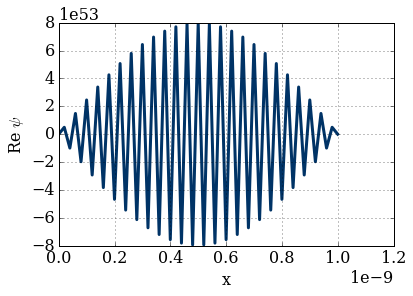

In [8]:
# Plot of real values of wave packet vs. x

pyplot.plot(x, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)
pyplot.xlabel(r'x')
pyplot.ylabel(r'Re $\psi$')

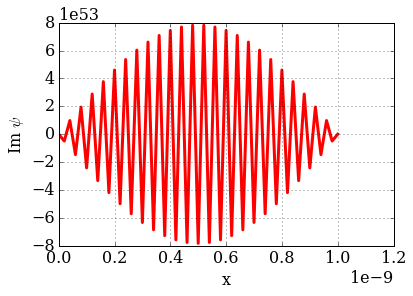

In [9]:
# Plot of imaginary values of wave packet vs. x

pyplot.plot(x, psi.imag, color='r', ls='-', lw=3);
pyplot.grid(True)
pyplot.xlabel(r'x')
pyplot.ylabel(r'Im $\psi$')
pyplot.title(r'')

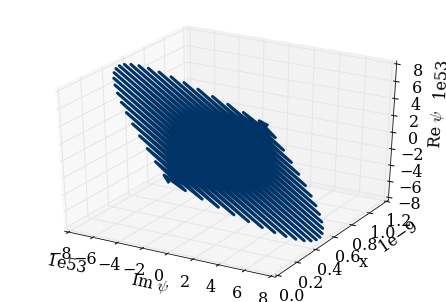

In [10]:
# 3D plot of imaginary values vs. real vales vs. x 

fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init()
ax.plot(psi.imag, x, psi.real, color = '#003366', lw =3)
ax.set_xlabel(r'Im $\psi$')
ax.set_ylabel(r'x')
ax.set_zlabel(r'Re $\psi$')

In [11]:
"""
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

fig = pyplot.figure();
ax = pyplot.axes(xlim = (0,L), ylim = (-5,5))
line, = ax.plot([],[],lw = 2)

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.imag, interval = 50)

display_animation(anim, default_mode = 'once')
"""

"\nfrom matplotlib import animation\nfrom JSAnimation.IPython_display import display_animation\n\nfig = pyplot.figure();\nax = pyplot.axes(xlim = (0,L), ylim = (-5,5))\nline, = ax.plot([],[],lw = 2)\n\ndef animate(data):\n    x = numpy.linspace(0, L, nx)\n    y = data\n    line.set_data(x, y)\n    return line,\n\nanim = animation.FuncAnimation(fig, animate, frames = psi.imag, interval = 50)\n\ndisplay_animation(anim, default_mode = 'once')\n"

In [12]:
# Compute the probability density function

psi_conj = numpy.conj(psi)     #conjugate of wave equation values
probfunc = psi_conj*psi        #probability density function of wave equation 

print(psi_conj)

[  1.00000000e+00 -0.00000000e+00j   4.97187366e+52 +4.89395173e+52j
  -9.94374732e+52 -9.78790346e+52j   1.48763652e+53 +1.46432147e+53j
  -1.97502544e+53 -1.94407176e+53j   2.45461739e+53 +2.41614728e+53j
  -2.92451904e+53 -2.87868438e+53j   3.38287533e+53 +3.32985705e+53j
  -3.82787675e+53 -3.76788416e+53j   4.25776654e+53 +4.19103649e+53j
  -4.67084759e+53 -4.59764351e+53j   5.06548914e+53 +4.98610002e+53j
  -5.44013324e+53 -5.35487249e+53j   5.79330087e+53 +5.70250509e+53j
  -6.12359780e+53 -6.02762542e+53j   6.42972009e+53 +6.32895000e+53j
  -6.71045924e+53 -6.60528925e+53j   6.96470694e+53 +6.85555224e+53j
  -7.19145949e+53 -7.07875100e+53j   7.38982171e+53 +7.27400438e+53j
  -7.55901052e+53 -7.44054156e+53j   7.69835798e+53 +7.57770510e+53j
  -7.80731399e+53 -7.68495349e+53j   7.88544842e+53 +7.76186335e+53j
  -7.93245280e+53 -7.80813105e+53j   7.94814157e+53 +7.82357394e+53j
  -7.93245280e+53 -7.80813105e+53j   7.88544842e+53 +7.76186335e+53j
  -7.80731399e+53 -7.68495349e+53j

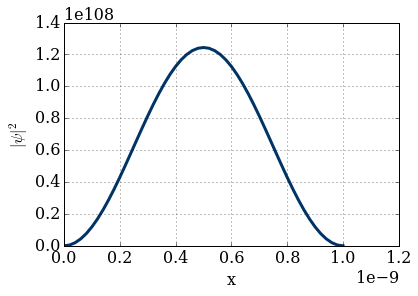

In [13]:
# Plot of probability density function vs. x

pyplot.plot(x, probfunc.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)
pyplot.xlabel(r'x')
pyplot.ylabel(r'$|\psi|^2$')

In [14]:
def psi_analytical(x, t, n_max, h, m, L, hbar):
    
    """
    Computes the analytical solution of the Schrodinger equation
    to evaluate at various quantum numbers
    
    Boundary conditions:
    psi = 0 at x = 0 
    psi = 0 at x = L
    
    Parameters :
    ----------
    x : array of float
        values of x stepping from 0 to L
    t : float
        time
    n_max : int
        maximum quantum number set to evaluate
    h : float
        Planck's constant
    m : float
        mass of particle
    L : float
        length of box
    hbar : float
        h/2pi
    
    Returns :
    ----------
    psi : array of floats
        wave equation values at different spatial positions
    """
    
    #Boundary condition
    psi = 0
    
    for n in range (1, n_max+1):
        
        E = ((n**2)*(h**2))/(8*m*(L**2))
        
        sum = numpy.sqrt(2/L)*numpy.sin(n*numpy.pi*x/L)*numpy.exp(-1j*E*t/hbar)
        psi+= sum
        
    return psi


In [15]:
# Compute the values for the analytical solution

n = 1      # quantum number

psi_analytical = psi_analytical(x, dt*nt, n, h, m, L, hbar)

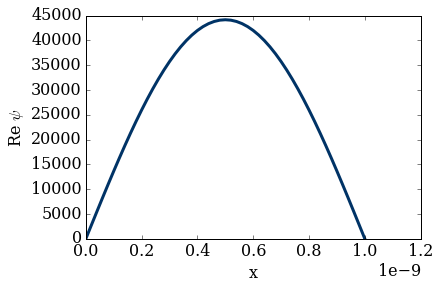

In [16]:
# Plot of real values of wave equation vs. x

pyplot.plot(x, psi_analytical.real, color = '#003366', ls = '-', lw =3)
pyplot.xlabel(r'x')
pyplot.ylabel(r'Re $\psi$')

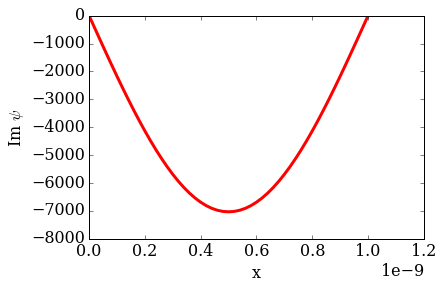

In [17]:
# Plot of imaginary values of wave equation vs. x

pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)
pyplot.xlabel(r'x')
pyplot.ylabel(r'Im $\psi$')

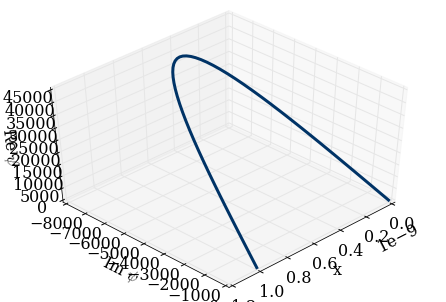

In [18]:
# 3D plot of imaginary values vs. real vales vs. x 

fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init(45,45)
ax.plot(x, psi_analytical.imag, psi_analytical.real, color = '#003366', lw =3)
ax.set_xlabel(r'x')
ax.set_ylabel(r'Im $\psi$')
ax.set_zlabel(r'Re $\psi$')

In [19]:
# Compute the probability density function for the analytical solution

psi_analytical_conj = numpy.conj(psi_analytical)     #conjugate of wave equation values
probfunc_analytical = psi_analytical_conj*psi_analytical        #probability density function of wave equation 

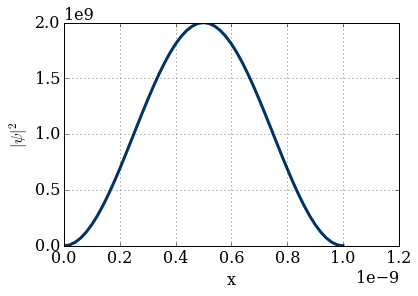

In [20]:
# Plot of probability density function vs. x

pyplot.plot(x, probfunc_analytical.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)
pyplot.xlabel(r'x')
pyplot.ylabel(r'$|\psi|^2$')

In [21]:
"""
fig = pylab.figure()
ax = Axes3D(fig)
ax.viewinit()

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')
"""

"\nfig = pylab.figure()\nax = Axes3D(fig)\nax.viewinit()\n\ndef animate(data):\n    x = numpy.linspace(0, L, nx)\n    y = data\n    line.set_data(x, y)\n    return line,\n\nanim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)\n\ndisplay_animation(anim, default_mode = 'once')\n"

## References -- move to bottom
* Atkins & Friedman (Molecular Quantum Mechanics textbook)
* Barba, Lorena A., et al. "MAE 6286 Practical Numerical Methods with Python." The George Washington University. http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about. 2014
* http://arxiv.org/pdf/0704.3240.pdf
* http://phys.au.dk/fileadmin/site_files/publikationer/phd/Thomas_Kim_Kjeldsen.pdf
* https://en.wikipedia.org/wiki/Wave_packet

In [22]:
from IPython.core.display import HTML
css_file = '../../numerical-mooc/styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())